In [3]:
import pandas as pd
import numpy as np
from glob import glob
from re import match, sub
from missingno import matrix as mmatrix
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from math import ceil
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from os import listdir
from statsmodels.formula.api import ols

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [5]:
if 'figure_dir.txt' in listdir():
    with open('figure_dir.txt', 'r') as f:
        fig_dir = f.readline().strip().replace('\\', '/')
        tbl_dir = f"{fig_dir.rsplit('/', maxsplit=2)[0]}/Tables/"
else:
    fig_dir = 'Figures/'
    tbl_dir = 'Tables/'

def trim_trailing_zeros(number_string):
    '''
    Take a string with numbers and remove any trailing zeros from the number.
    '''
    return sub(
        r'(?:\.0+|(\.\d+)0+)(%?)$', 
        '\\1\\2', number_string
    )

def neaten_ticks(
        ax, axis, tick_range, ticks, dp=0, fmt='f', twin=False
    ):
    '''
    Take a plot ax and convert its x or y axis into a neatened range frame.
    '''
    # Set sets.
    eval(f"ax.set_{axis}ticks")(sorted([*ticks, *tick_range]))
    is_log = eval(f"ax.get_{axis}scale")() == 'log' 
    # Set labels.
    eval(f"ax.set_{axis}ticklabels")([
        f"$\\mathdefault{{10^{{{ex:.0f}}}}}$" 
        if is_log and int((ex := np.log10(e))) == ex 
        else trim_trailing_zeros(eval(f'''f"{{e:.0{dp}{fmt}}}"'''))
        for e in eval(f"ax.get_{axis}ticks")()
    ])
    # Limit axis outline to data range.
    ax.spines[
        'right' if twin else 'bottom' if axis == 'x' else 'left'
    ].set_bounds(*tick_range)

def show(
    fig, axes=[], tight=False, despine=True, despine_twin=False, 
    delax=True, file=None, legend_loc=0, filetype='pdf'
):
    '''Style and show a matplotlib plot.'''
    if tight: plt.tight_layout() # Neaten subplots.
    # Remove unnecessary outlines from plots with twin axes.
    # Note that this method assumes all axes have twins.
    if despine_twin:
        for ax in axes[::2]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        for ax in axes[1::2]:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
    # Remove unnecessary outlines.
    elif despine:
        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    for ax in axes:
    # Remove unused subplots.
        if delax and not ax.has_data(): fig.delaxes(ax)
        ax.tick_params(
            axis='both', which='minor', 
            bottom=False, left=False, right=False
        )
        # Style the legend if a legend is present.
        if ax.get_legend():
            handles, labels = ax.get_legend_handles_labels()
            labels = [e.title() for e in labels]
            legend_title = ax.get_legend().get_title().get_text().title()
            ax.legend(
                handles=handles, labels=labels, 
                title=legend_title, loc=legend_loc
            )
    # Save file if a filename is provided.
    if file:
        plt.savefig(
            f'{fig_dir}/Plots/{file}.{filetype}', dpi = 300,
            bbox_inches = 'tight', pad_inches = 1/25
        )
    plt.show()
    

In [6]:
CSVs = glob('data/*/*.csv')

for csv in CSVs:
    csv = csv.replace('\\', '/')
    file = match(r'data.*/(.*?)\.csv', csv).group(1)
    print(file)
    exec(f'{file} = pd.read_csv("{csv}")')
    exec(f'{file}["state"] = "{file.split('_')[-1].upper()}"')


temprature_qld
totaldemand_qld
temprature_sa
totaldemand_sa
forecastdemand_qld
forecastdemand_vic
totaldemand_vic
forecastdemand_sa
temprature_vic
totaldemand_nsw
forecastdemand_nsw
temperature_nsw


In [8]:
def get_metadata(data, name):
    return {
        'Dataset': name, 
        'Records': len(data), 
        'Variables': len([e for e in data.columns if e != 'state']),
        'Size in memory (MB)': data.drop(columns=['state']).memory_usage(deep=True).sum() / 1e6
    }

metadata = []


In [9]:
dem = pd.concat([totaldemand_qld, totaldemand_sa, totaldemand_vic])

dem.DATETIME = pd.to_datetime(dem.DATETIME, format="%Y-%m-%d %H:%M:%S")
totaldemand_nsw.DATETIME = pd.to_datetime(totaldemand_nsw.DATETIME, format="%d/%m/%Y %H:%M")
dem = pd.concat([dem, totaldemand_nsw]).reset_index(drop=True)
# dem = dem.drop(columns=['REGIONID'])

dem = dem[dem.state == 'NSW'].reset_index(drop=True)

# print(dem.isnull().sum())

metadata.append(get_metadata(dem, 'totaldemand_nsw'))

dem


,DATETIME,TOTALDEMAND,REGIONID,state
0,2010-01-01 00:00:00,8038.00,NSW1,NSW
1,2010-01-01 00:30:00,7809.31,NSW1,NSW
2,2010-01-01 01:00:00,7483.69,NSW1,NSW
3,2010-01-01 01:30:00,7117.23,NSW1,NSW
4,2010-01-01 02:00:00,6812.03,NSW1,NSW
...,...,...,...,...
196508,2021-03-17 22:00:00,7419.77,NSW1,NSW
196509,2021-03-17 22:30:00,7417.91,NSW1,NSW
196510,2021-03-17 23:00:00,7287.32,NSW1,NSW
196511,2021-03-17 23:30:00,7172.39,NSW1,NSW


In [10]:
fore = pd.concat([
    forecastdemand_qld, forecastdemand_sa, forecastdemand_vic, forecastdemand_nsw
])

fore = fore[fore.state == 'NSW'].reset_index(drop=True)

for col in ["LASTCHANGED", "DATETIME"]:
    fore[col] = pd.to_datetime(fore[col], format="%Y-%m-%d %H:%M:%S")

metadata.append(get_metadata(fore, 'forecastdemand_nsw'))

fore = fore[fore.PERIODID.isin([2, 48])].drop_duplicates()\
    .reset_index(drop=True).drop(columns=['REGIONID'])

print(fore.isnull().sum())

# fore_piv = fore.pivot(columns='PERIODID', index='DATETIME', values='FORECASTDEMAND').reset_index()
# fore_piv.columns = [e if e=='DATETIME' else f"h{e/2:.0f}_ahead" for e in fore_piv.columns]

fore


PREDISPATCHSEQNO    0
PERIODID            0
FORECASTDEMAND      0
LASTCHANGED         0
DATETIME            0
state               0
dtype: int64


,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME,state
0,2009123041,48,7822.38,2009-12-31 00:01:34,2010-01-01 00:00:00,NSW
1,2009123139,2,7789.50,2009-12-31 23:01:24,2010-01-01 00:00:00,NSW
2,2009123042,48,7715.68,2009-12-31 00:31:25,2010-01-01 00:30:00,NSW
3,2009123140,2,7603.17,2009-12-31 23:31:32,2010-01-01 00:30:00,NSW
4,2009123043,48,7482.56,2009-12-31 01:01:17,2010-01-01 01:00:00,NSW
...,...,...,...,...,...,...
327495,2021031737,2,7316.62,2021-03-17 22:01:34,2021-03-17 23:00:00,NSW
327496,2021031640,48,7011.96,2021-03-16 23:31:34,2021-03-17 23:30:00,NSW
327497,2021031738,2,7187.72,2021-03-17 22:31:36,2021-03-17 23:30:00,NSW
327498,2021031641,48,6932.43,2021-03-17 00:01:34,2021-03-18 00:00:00,NSW


In [11]:
temp = pd.concat([temprature_qld, temperature_nsw, temprature_vic])

temp.DATETIME = pd.to_datetime(temp.DATETIME, format="%d/%m/%Y %H:%M")

temprature_sa.DATETIME = pd.to_datetime(temprature_sa.DATETIME, format="%Y-%m-%d %H:%M:%S")
temp = pd.concat([temp, temprature_sa])\
    .drop(columns = ['Unnamed: 0']).reset_index(drop=True)

temp = temp[temp.state == 'NSW'].reset_index(drop=True)
metadata.append(get_metadata(temp, 'temperature_nsw'))

temp = temp.drop(columns=['LOCATION'])

print(temp.isnull().sum())

temp


DATETIME       0
TEMPERATURE    0
state          0
dtype: int64


,DATETIME,TEMPERATURE,state
0,2010-01-01 00:00:00,23.1,NSW
1,2010-01-01 00:01:00,23.1,NSW
2,2010-01-01 00:30:00,22.9,NSW
3,2010-01-01 00:50:00,22.7,NSW
4,2010-01-01 01:00:00,22.6,NSW
...,...,...,...
220321,2021-03-17 23:00:00,19.1,NSW
220322,2021-03-17 23:20:00,19.0,NSW
220323,2021-03-17 23:30:00,18.8,NSW
220324,2021-03-17 23:34:00,18.8,NSW


In [22]:
mdata = pd.DataFrame(metadata)

mdata = mdata.style.hide()\
    .format("{:,.02f}", subset=['Size in memory (MB)'])\
    .format("{:,}", subset=['Records'])\
    .format(escape="latex", subset=['Dataset'])
display(mdata)

mdata_tex = mdata.to_latex(
        label='metadata', position_float="centering", hrules=True, position='H',
        caption = "Metadata of the datasets being used. Size in memory refers to the space used after formatting, where each value is represented by an appropriate Python object (e.g. datetime values are in Timestamp format)."
)
mdata_tex = sub(r'(?s)(^.*)(\\caption{.*?}\n\\label{.*?}\n)(.*)(\\end{table})', r'\1\3\2\4', mdata_tex)
print(mdata_tex)

with open(f"{tbl_dir}/metadata.tex", 'w') as f:
    f.write(mdata_tex)


Dataset,Records,Variables,Size in memory (MB)
totaldemand\_nsw,"196,513",3,13.56
forecastdemand\_nsw,"10,906,019",6,"1,014.26"
temperature\_nsw,"220,326",3,16.30


\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
Dataset & Records & Variables & Size in memory (MB) \\
\midrule
totaldemand\_nsw & 196,513 & 3 & 13.56 \\
forecastdemand\_nsw & 10,906,019 & 6 & 1,014.26 \\
temperature\_nsw & 220,326 & 3 & 16.30 \\
\bottomrule
\end{tabular}
\caption{Metadata of the datasets being used. Size in memory refers to the space used after formatting, where each value is represented by an appropriate Python object (e.g. datetime values are in Timestamp format).}
\label{metadata}
\end{table}



In [21]:
df = pd.merge(temp, dem, on=['DATETIME', 'state'], how='outer')\
    .dropna()

# ohe = OneHotEncoder(sparse_output=False)
# df[sorted(df.state.unique())] = ohe.fit_transform(df.state.to_numpy().reshape(-1, 1))
# df = df.drop(columns=['state'])
df['hour'] = df.DATETIME.dt.strftime('%H').astype(int)
df['day'] = df.DATETIME.dt.strftime('%w').astype(int)
df['month'] = df.DATETIME.dt.strftime('%m').astype(int)
df['year'] = df.DATETIME.dt.strftime('%Y').astype(int)
df['day_label'] = df.DATETIME.dt.strftime('%a')
df['is_weekday'] = df.day.between(1, 5)
ohe_day = OneHotEncoder(sparse_output=False)
df[sorted(df.day_label.unique())] = ohe_day.fit_transform(df.day_label.to_numpy().reshape(-1, 1))

h1_ahead = df.copy()[['DATETIME', 'TOTALDEMAND']].rename(columns={'TOTALDEMAND': 'h1_ahead'})
h1_ahead['h1_hour'] = h1_ahead.DATETIME.dt.strftime('%H').astype(int)
h1_ahead['h1_day'] = h1_ahead.DATETIME.dt.strftime('%w').astype(int)
h1_ahead['h1_month'] = h1_ahead.DATETIME.dt.strftime('%m').astype(int)
h1_ahead['h1_year'] = h1_ahead.DATETIME.dt.strftime('%Y').astype(int)
h1_ahead.DATETIME -= timedelta(hours=1)
h24_ahead = df.copy()[['DATETIME', 'TOTALDEMAND']].rename(columns={'TOTALDEMAND': 'h24_ahead'})
h24_ahead['h24_hour'] = h24_ahead.DATETIME.dt.strftime('%H').astype(int)
h24_ahead['h24_day'] = h24_ahead.DATETIME.dt.strftime('%w').astype(int)
h24_ahead['h24_month'] = h24_ahead.DATETIME.dt.strftime('%m').astype(int)
h24_ahead['h24_year'] = h24_ahead.DATETIME.dt.strftime('%Y').astype(int)
h24_ahead.DATETIME -= timedelta(days=1)

for ahead in [h1_ahead, h24_ahead]:
    df = pd.merge(df, ahead, how='left', on='DATETIME')

df = df.drop(columns=['day']).dropna().drop_duplicates().reset_index(drop=True)

df.to_csv('data/modelling_data.csv', lineterminator='\n', index=False)

df


,DATETIME,TEMPERATURE,state,TOTALDEMAND,REGIONID,hour,month,year,day_label,is_weekday,...,h1_ahead,h1_hour,h1_day,h1_month,h1_year,h24_ahead,h24_hour,h24_day,h24_month,h24_year
0,2010-01-01 00:00:00,23.1,NSW,8038.00,NSW1,0,1,2010,Fri,True,...,7483.69,1.0,5.0,1.0,2010.0,7574.85,0.0,6.0,1.0,2010.0
1,2010-01-01 00:30:00,22.9,NSW,7809.31,NSW1,0,1,2010,Fri,True,...,7117.23,1.0,5.0,1.0,2010.0,7343.30,0.0,6.0,1.0,2010.0
2,2010-01-01 01:00:00,22.6,NSW,7483.69,NSW1,1,1,2010,Fri,True,...,6812.03,2.0,5.0,1.0,2010.0,7099.73,1.0,6.0,1.0,2010.0
3,2010-01-01 01:30:00,22.5,NSW,7117.23,NSW1,1,1,2010,Fri,True,...,6544.33,2.0,5.0,1.0,2010.0,6779.80,1.0,6.0,1.0,2010.0
4,2010-01-01 02:00:00,22.5,NSW,6812.03,NSW1,2,1,2010,Fri,True,...,6377.32,3.0,5.0,1.0,2010.0,6497.47,2.0,6.0,1.0,2010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195207,2021-03-16 22:00:00,20.4,NSW,7373.83,NSW1,22,3,2021,Tue,True,...,7218.99,23.0,2.0,3.0,2021.0,7419.77,22.0,3.0,3.0,2021.0
195208,2021-03-16 22:30:00,20.5,NSW,7345.78,NSW1,22,3,2021,Tue,True,...,7056.88,23.0,2.0,3.0,2021.0,7417.91,22.0,3.0,3.0,2021.0
195209,2021-03-16 23:00:00,20.3,NSW,7218.99,NSW1,23,3,2021,Tue,True,...,6999.23,0.0,3.0,3.0,2021.0,7287.32,23.0,3.0,3.0,2021.0
195210,2021-03-16 23:30:00,19.7,NSW,7056.88,NSW1,23,3,2021,Tue,True,...,6849.85,0.0,3.0,3.0,2021.0,7172.39,23.0,3.0,3.0,2021.0


In [204]:
import tensorflow as tf
# from tensorflow import keras # for building Neural Networks
# from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MAPE, MeanAbsolutePercentageError, MSE
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed, LSTM # for creating layers inside the Neural Network
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from scikeras.wrappers import KerasClassifier


In [89]:
X_cols = [
    'TEMPERATURE', 'TOTALDEMAND', 'hour', 'is_weekday', 
    'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', 
    'h1_hour', 'h1_day', 'h24_hour', 'h24_day'
]
y_cols = ['h1_ahead', 'h24_ahead']
X_y_df = df.dropna()[X_cols + y_cols].astype(float).dropna()
X_df = X_y_df.drop(columns=y_cols)
y_df = X_y_df[y_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

X_y = [X_train, X_test, y_train, y_test] = train_test_split(
    X_scaled, y_df, test_size=0.2, shuffle=False
)
X_y = [tf.convert_to_tensor(d) for d in X_y]
[X_train, X_test, y_train, y_test] = X_y

train_val_I = TimeSeriesSplit(n_splits=10).split(X_train)

for train, val in train_val_I:
    print(train.shape, val.shape)

X_val = X_train[train.max()+1:]
y_val = y_train[train.max()+1:]
X_train = X_train[:train.max()+1]
y_train = y_train[:train.max()+1]

X_train


(14201,) (14200,)
(28401,) (14200,)
(42601,) (14200,)
(56801,) (14200,)
(71001,) (14200,)
(85201,) (14200,)
(99401,) (14200,)
(113601,) (14200,)
(127801,) (14200,)
(142001,) (14200,)


<tf.Tensor: shape=(142001, 15), dtype=float64, numpy=
array([[ 0.94649374, -0.05567114, -1.66164249, ...,  0.9998208 ,
        -1.66164249,  1.50049862],
       [ 0.91249148, -0.23185127, -1.66164249, ...,  0.9998208 ,
        -1.66164249,  1.50049862],
       [ 0.86148809, -0.48270515, -1.51722703, ...,  0.9998208 ,
        -1.51722703,  1.50049862],
       ...,
       [ 0.3514542 ,  0.17858858, -0.65073423, ...,  0.9998208 ,
        -0.65073423,  1.50049862],
       [ 0.43645985,  0.21721585, -0.65073423, ...,  0.9998208 ,
        -0.65073423,  1.50049862],
       [ 0.53846663,  0.22083668, -0.50631877, ...,  0.9998208 ,
        -0.50631877,  1.50049862]])>

In [48]:
for h in [1, 24]:
        print(f'H{h}'.rjust(3) + ':', ols(
            f"\
h{h}_ahead ~ TEMPERATURE + I(TEMPERATURE**2) + I(TEMPERATURE**3) + I(TEMPERATURE**4) + is_weekday + \
             TOTALDEMAND + I(TOTALDEMAND**2) + I(TOTALDEMAND**3) + I(TOTALDEMAND**4)", X_y_df
        ).fit().rsquared)


 H1: 0.9000379489717799
H24: 0.7689802695196182


In [306]:
main_input = Input(shape=tuple(X_train[0].shape), name="input")
previous_layer = main_input
for i in range(5):
    # previous_layer = BatchNormalization()(previous_layer)
    previous_layer = Dense(32, name=f"linear_{i+1}", activation='linear')(previous_layer)
    previous_layer = Dense(32, name=f"relu_{i+1}", activation='relu')(previous_layer)
main_output = Dense(2, name=f"output")(previous_layer)

model_mlp = Model(inputs=main_input, outputs=main_output, name="MLP")

def scheduler(epoch, lr):
    return 0.0001 if epoch % 2 == 1 else 0.001

model_mlp.compile(optimizer=Adam(
    learning_rate=.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=1e-4, # Try 1e-5 next.
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    name='Adam',
), loss=MeanAbsolutePercentageError(), metrics=[MSE])
mlp_history = model_mlp.fit(
    X_train, y_train, verbose=1, validation_data=(X_val, y_val), shuffle=False,
    epochs=1000, batch_size=2**10, 
    callbacks=[
        LearningRateScheduler(scheduler), 
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True), 
    ]
)



Epoch 1/1000
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 82.5977 - mean_squared_error: 60423864.0000 - val_loss: 7.5328 - val_mean_squared_error: 604722.7500 - learning_rate: 0.0010
Epoch 2/1000
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6983 - mean_squared_error: 633681.6250 - val_loss: 5.3222 - val_mean_squared_error: 338805.4375 - learning_rate: 1.0000e-04
Epoch 3/1000
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3733 - mean_squared_error: 406986.0938 - val_loss: 4.6468 - val_mean_squared_error: 268451.0312 - learning_rate: 0.0010
Epoch 4/1000
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4636 - mean_squared_error: 309605.2188 - val_loss: 4.0714 - val_mean_squared_error: 217364.7344 - learning_rate: 1.0000e-04
Epoch 5/1000
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3243 - mean_squared_error: 285922.2812 - val_loss: 5.4735 - val_mean_squared_error: 301704.5625 - learning_rate: 0.0010
Epoch 6/1000
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3434 

444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step  LR=0.001  
 H1: 4.240765  
H24: 6.148738  

444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step  LR=0.005  
 H1: 3.9365637  
H24: 5.207623  

444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step  0.0001 if epoch % 2 == 1 else 0.001  
 H1: 2.107532  
H24: 3.7242785  
  
 H1: 1.758341  
H24: 3.5942032  

 H1 MAPE: 1.7688993  
H24 MAPE: 3.1515892  
  
 H1 MAPE: 1.7246057  
H24 MAPE: 3.1756434  

**weight_decay=1e-3**  
 H1 MAPE: 1.8311229  
H24 MAPE: 3.1929262  

 H1 MAPE: 1.8760741  
H24 MAPE: 3.2319467  

**weight_decay=1e-4**  
 H1 MAPE: 1.8524495  
H24 MAPE: 3.2066095  

444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step  LR=0.0001  
 H1: 3.3002746  
H24: 4.63978  

 H1: 3.2177918  
H24: 4.7140837  

444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step  0.0001 if epoch % 2 == 1 else 0.001  AND  batch_size=2**10  
 H1: 1.6170247  
H24: 3.1505651  


444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
 H1 MAPE: 1.8524495
H24 MAPE: 3.2066095
 H1 R2: 0.9559594607597063
H24 R2: 0.8883022506075946


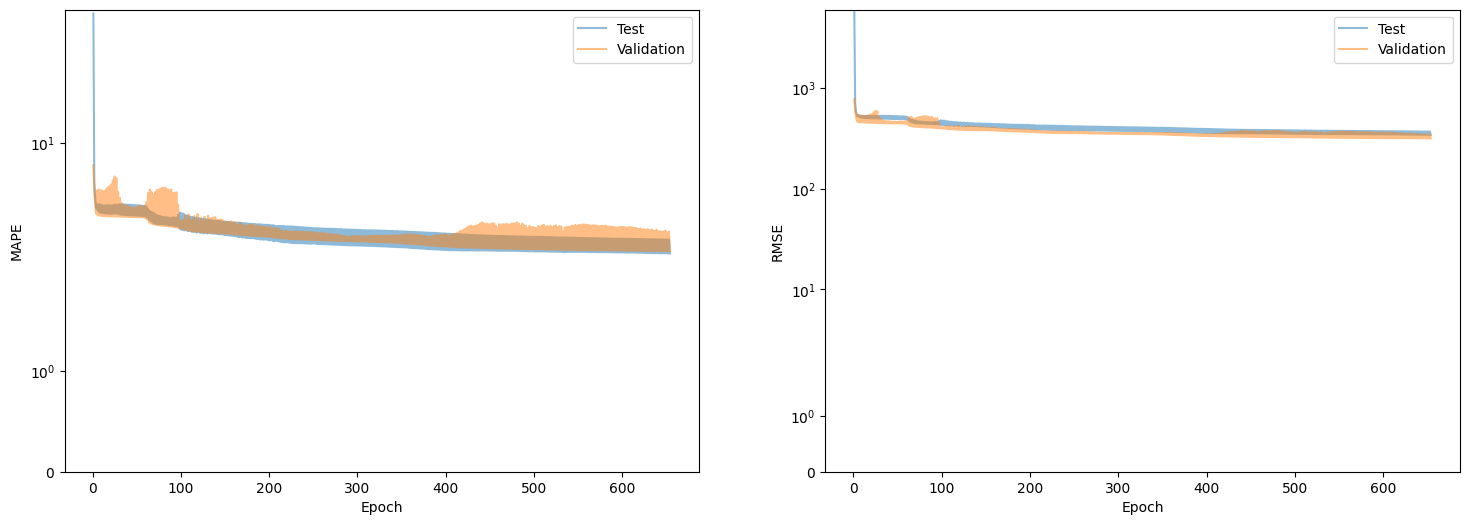

In [307]:
y_pred = model_mlp.predict(X_val)
for i in range(2):
    print(('H24' if i else 'H1'.rjust(3)) + ' MAPE:', MAPE(y_val[:,i], y_pred[:,i]).numpy())
for i in range(2):
    print(('H24' if i else 'H1'.rjust(3)) + ' R2:', r2_score(y_val[:,i], y_pred[:,i]))

mlp_history_df = pd.DataFrame(mlp_history.history)
mlp_history_df['epoch'] = (mlp_history_df.index+1).to_list()
mse_cols = [e for e in mlp_history_df.columns if 'mean_squared_error' in e]
mlp_history_df[[e.replace('mean_squared_error', 'RMSE') for e in mse_cols]] = mlp_history_df[mse_cols].apply(lambda d: d.apply(lambda e: e**.5), axis=1)

fig, axes = plt.subplots(1, 2, figsize=(18,6))
metrics = ['loss', 'RMSE']

for i, ax in enumerate(axes):

    metric = metrics[i]
    label = metric.replace('loss', 'MAPE')

    sns.lineplot(mlp_history_df, x='epoch', y=metric, ax=ax, label='Test', alpha=0.5)
    sns.lineplot(mlp_history_df, x='epoch', y=f"val_{metric}", ax=ax, label='Validation', alpha=0.5)

    ax.set_ylim(0)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(label)
    ax.set_yscale('symlog')
    
plt.show()
    


In [248]:
main_input = Input(shape=(X_train[0].shape[0],1), name="input")
previous_layer = main_input
previous_layer = Bidirectional(LSTM(64, return_sequences=True), name=f"BD_1")(previous_layer)
previous_layer = Bidirectional(LSTM(32), name=f"BD_2")(previous_layer)

previous_layer = Dense(32, name=f"relu_{1}", activation='relu')(previous_layer)
main_output = Dense(2, name=f"output")(previous_layer)

def scheduler(epoch, lr):
    return 0.001 if epoch % 2 == 1 else 0.01

model_lstm = Model(inputs=main_input, outputs=main_output, name="BD-LSTM")
model_lstm.compile(optimizer=Adam(
    learning_rate=.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    name='Adam',
), loss=MeanAbsolutePercentageError(), metrics=[MSE])
lstm_history = model_lstm.fit(
    X_train, y_train, verbose=1, validation_data=(X_val, y_val), shuffle=False,
    epochs=1000, batch_size=2**5, 
    callbacks=[
        LearningRateScheduler(scheduler), 
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True), 
    ]
)

# LSTM(Hidden, activation='relu')
# batch_size=64, verbose=0, shuffle=False


Epoch 1/1000
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 20.7106 - mean_squared_error: 10166402.0000 - val_loss: 5.2928 - val_mean_squared_error: 391766.9375 - learning_rate: 0.0100
Epoch 2/1000
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 4.2838 - mean_squared_error: 302565.7500 - val_loss: 3.9626 - val_mean_squared_error: 199187.7969 - learning_rate: 0.0010
Epoch 3/1000
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 4.3101 - mean_squared_error: 274474.0000 - val_loss: 4.4120 - val_mean_squared_error: 253933.4844 - learning_rate: 0.0100
Epoch 4/1000
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 4.0149 - mean_squared_error: 255520.8281 - val_loss: 3.8214 - val_mean_squared_error: 184829.7344 - learning_rate: 0.0010
Epoch 5/1000
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 4.0606 - mean_squared_error: 253127.0938 - val_loss: 4.2436 - val_mean_squared_error: 235522.3906 - learning_rate: 0.0100
Epoch 6/1000
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - los

KeyboardInterrupt: 

444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  LR=0.01  
 H1: 1.8942682  
H24: 3.261359  
  
 H1: 2.3578866  
H24: 3.7653885  

444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  LR=0.001  
 H1: 2.2099416  
H24: 3.548185  

444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  0.0001 if epoch % 2 == 1 else 0.001  (Epoch 154/1000)  
 H1: 1.4781239  
H24: 3.2230973  


444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 H1: 1.4781239
H24: 3.2230973


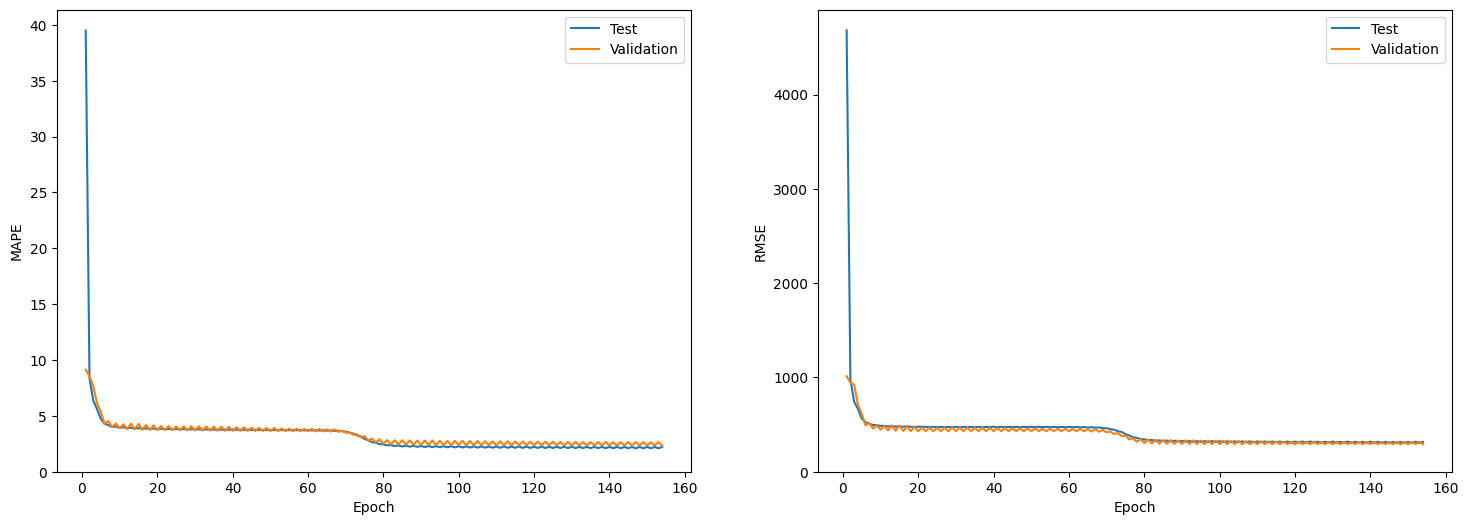

In [246]:
y_pred = model_lstm.predict(X_val)
for i in range(2):
    print(('H24' if i else 'H1'.rjust(3)) + ':', MAPE(y_val[:,i], y_pred[:,i]).numpy())

lstm_history_df = pd.DataFrame(lstm_history.history)
lstm_history_df['epoch'] = (lstm_history_df.index+1).to_list()
mse_cols = [e for e in lstm_history_df.columns if 'mean_squared_error' in e]
lstm_history_df[[e.replace('mean_squared_error', 'RMSE') for e in mse_cols]] = lstm_history_df[mse_cols].apply(lambda d: d.apply(lambda e: e**.5), axis=1)

fig, axes = plt.subplots(1, 2, figsize=(18,6))
metrics = ['loss', 'RMSE']

for i, ax in enumerate(axes):

    metric = metrics[i]
    label = metric.replace('loss', 'MAPE')

    sns.lineplot(lstm_history_df, x='epoch', y=metric, ax=ax, label='Test')
    sns.lineplot(lstm_history_df, x='epoch', y=f"val_{metric}", ax=ax, label='Validation')

    ax.set_ylim(0)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(label)
    
plt.show()


In [55]:
start = datetime.now()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

mlp = MLPRegressor(
    hidden_layer_sizes=(10, 10, 10, 10, 10), solver='adam', 
    max_iter=1000, random_state=1
)
mlp.fit(X=X_train_scaled, y=y_train)
y_pred = mlp.predict(X_val_scaled)

print('Train time:', datetime.now() - start)
print('R-squared:', r2_score(y_val, y_pred))

mlp


Train time: 0:00:19.339882
R-squared: 0.9947232481914644


MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10, 10), max_iter=1000,
             random_state=1)

**MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=1)**  
Train time: 0:02:50.626288  
R-squared: 0.903996701869163  

**MLPRegressor(hidden_layer_sizes=(30, 30, 30), max_iter=1000, random_state=1)**  
Train time: 0:07:13.764777  
R-squared: 0.9029300360828791  

  
**MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=1)**  
Train time: 0:04:49.145756  
R-squared: 0.904020785674071  

**MLPRegressor(hidden_layer_sizes=(100), max_iter=1000, random_state=1)**  
Train time: 0:30:34.488262  
R-squared: 0.9042026519524867  
  
**MLPRegressor(hidden_layer_sizes=(1,), max_iter=1000, random_state=1)**  
Train time: 0:15:16.664206  
R-squared: -1.2258165361865667  

**MLPRegressor(hidden_layer_sizes=(5, 5, 5), max_iter=1000, random_state=1)**  
Train time: 0:07:20.061461  
R-squared: 0.9029303895811518  
  
**MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10, 10), max_iter=1000, random_state=1)**  
Train time: 0:00:54.204514  
R-squared: 0.903889951968013  

**MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10, 10, 10, 10, 10, 10, 10), max_iter=1000, random_state=1)**  
Train time: 0:02:17.239752  
R-squared: 0.8997796694909751  

**MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10, 10), max_iter=1000, random_state=1, solver='sgd')**  
Train time: 0:10:37.488748  
R-squared: -2.325212494791451e-05  




In [121]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from urllib.parse import quote_plus


In [132]:
uri = "mongodb+srv://<user>:<password>@project-data.cfluj8d.mongodb.net/?retryWrites=true&w=majority&appName=project-data"\
    .replace('<user>', quote_plus(user)).replace('<password>', quote_plus(psw))

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
client.admin.command('ping')
print("Pinged your deployment. You successfully connected to MongoDB!")



Pinged your deployment. You successfully connected to MongoDB!


In [207]:
print(client.list_database_names())


['data', 'admin']
['forecast_demand', 'total_demand', 'temperature']


In [208]:
# client['data']['temperature'].insert_many(temp.to_dict(orient='records'))
# client['data']['total_demand'].insert_many(dem.to_dict(orient='records'))
# client['data']['forecast_demand'].insert_many(fore.to_dict(orient='records'))


In [210]:
for col in client['data'].list_collection_names():
    print(f"{col}: {client['data'][col].count_documents({}):,} records")
    

forecast_demand: 23,192,795 records
total_demand: 786,051 records
temperature: 778,177 records
